# Regression Week 4: Ridge Regression (gradient descent)

In this notebook, you will implement ridge regression via gradient descent. You will:
* Convert an SFrame into a Numpy array
* Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

# Fire up graphlab create

Make sure you have the latest version of GraphLab Create (>= 1.7)

In [4]:
import graphlab

A newer version of GraphLab Create (v1.8.3) is available! Your current version is v1.8.1.

You can use pip to upgrade the graphlab-create package. For more information see https://dato.com/products/create/upgrade.


# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [5]:
sales = graphlab.SFrame('kc_house_data.gl/')

[INFO] This non-commercial license of GraphLab Create is assigned to rkent719@gmail.com and will expire on January 16, 2017. For commercial licensing options, visit https://dato.com/buy/.

[INFO] Start server at: ipc:///tmp/graphlab_server-10784 - Server binary: /Users/ryankent/anaconda/envs/dato-env/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1456284155.log
[INFO] GraphLab Server Version: 1.8.1


If we want to do any "feature engineering" like creating new features or adjusting existing ones we should do this directly using the SFrames as seen in the first notebook of Week 2. For this notebook, however, we will work with the existing features.

# Import useful functions from previous notebook

As in Week 2, we convert the SFrame into a 2D Numpy array. Copy and paste `get_numpy_data()` from the second notebook of Week 2.

In [6]:
import numpy as np # note this allows us to refer to numpy as np instead 

In [7]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # add a constant column to an SFrame
    # prepend variable 'constant' to the features list
    features = ['constant'] + features
    # select the columns of data_SFrame given by the ‘features’ list into the SFrame ‘features_sframe’
    features_sframe = data_sframe[features]
    
    # this will convert the features_sframe into a numpy matrix with GraphLab Create >= 1.7!!
    features_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the target to the variable ‘output_sarray’
    output_sarray = data_sframe[output]

    # this will convert the SArray into a numpy array:
    output_array = output_sarray.to_numpy() # GraphLab Create>= 1.7!!
    return(features_matrix, output_array)

Also, copy and paste the `predict_output()` function to compute the predictions for an entire matrix of features given the matrix and the weights:

In [33]:
def predict_outcome(feature_matrix, weights):
    ''' Returns an array of predictions
    
    inputs - 
        feature_matrix - 2-D array of dimensions data points by features
        coefficients - 1-D array of estimated feature coefficients
        
    output - 1-D array of predictions
    '''
    predictions = np.dot(feature_matrix, weights)
    print predictions
    return(predictions)

# Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part.  As we saw, the derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which you should set to `True` when computing the derivative of the constant and `False` otherwise.

In [25]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant:
        derivative = 2 * np.dot(errors, feature)
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative = 2 * np.dot(errors, feature) + 2 * l2_penalty * weight
    
    return derivative

To test your feature derivartive run the following:

In [26]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False)
print np.sum(errors*example_features[:,1])*2+20.
print ''

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True)
print np.sum(errors)*2.

[ 11801.  25701.   7701. ...,  10201.  16001.  10201.]
-5.65541667824e+13
-5.65541667824e+13

-22446749336.0
-22446749336.0


# Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [51]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    weights = np.array(initial_weights) # make sure it's a numpy array
    k = 0
    #while not reached maximum number of iterations:
    while k < max_iterations:
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        pred = predict_outcome(feature_matrix, weights)
        # compute the errors as predictions - output
        residuals = pred-output
        for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            partial = feature_derivative_ridge(residuals, feature_matrix[:, i], weights[i], l2_penalty, i == 0)
            #print partial
            # subtract the step size times the derivative from the current weight
            weights[i] -= step_size*partial
        k = k + 1
    return weights

# Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [95]:
simple_features = ['sqft_living']
my_output = 'price'

Let us split the dataset into training set and test set. Make sure to use `seed=0`:

In [96]:
train_data,test_data = sales.random_split(.8,seed=0)

In this part, we will only use `'sqft_living'` to predict `'price'`. Use the `get_numpy_data` function to get a Numpy versions of your data with only this feature, for both the `train_data` and the `test_data`. 

In [97]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

Let's set the parameters for our optimization:

In [98]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_0_penalty`

we'll use them later.

In [99]:
l2_penalty = 0.0
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100)
print simple_weights_0_penalty

[ 0.  0.  0. ...,  0.  0.  0.]
[  55852.38491384  121644.57895112   36446.05429853 ...,   72418.7647074
   75732.04066611   48279.1827225 ]
[ 101653.8575441   221398.61568968   66333.46125655 ...,  131805.41535054
  137835.72691183   87870.28826115]
[ 139213.1291505   303201.42130152   90842.48182539 ...,  180505.14515975
  188763.5483616   120336.77897485]
[ 170013.42447687  370283.40840481  110940.98317438 ...,  220441.11827167
  230526.65703063  146960.76445638]
[ 195271.05465565  425293.66092722  127422.66000001 ...,  253190.41594705
  264774.28820533  168793.63235101]
[ 215983.44962938  470404.54707224  140938.37772178 ...,  280046.31589197
  292858.88914449  186697.56790934]
[ 232968.54690081  507397.50666603  152021.87531539 ...,  302069.36410788
  315889.52754929  201379.60189187]
[ 246897.0920831   537733.40064781  161110.84279422 ...,  320129.25611018
  334775.6889156   213419.531385  ]
[ 258319.12680666  562610.2008225   168564.20569407 ...,  334939.18141496
  350263.1923366

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_high_penalty`

we'll use them later.

In [53]:
l2_penalty = 1e11
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100)

[ 0.  0.  0. ...,  0.  0.  0.]
[  55852.38491384  121644.57895112   36446.05429853 ...,   72418.7647074
   75732.04066611   48279.1827225 ]
[  90483.38431187  197069.70365      59044.25414739 ...,  117321.6661596
  122689.32252915   78214.45546719]
[ 111956.16800904  243836.68309376   73056.15996247 ...,  145163.49195123
  151804.95673967   96775.67706404]
[ 125270.2647863   272834.3205418    81744.17639798 ...,  162426.68170315
  169857.96508652  108284.47419573]
[ 133525.60787153  290814.16489299   87131.14141196 ...,  173130.64021506
  181051.64668377  115420.45022877]
[ 138644.29561408  301962.48083112   90471.30572992 ...,  179767.57966154
  187992.23647103  119845.08004953]
[ 141818.11564066  308874.94118108   92542.36134456 ...,  183882.7839422
  192295.71760251  122588.55298852]
[ 143786.03000675  313160.98010983   93826.51235045 ...,  186434.39873774
  194964.07248394  124289.63287259]
[ 145006.22849994  315818.51935574   94622.74702449 ...,  188016.51756435
  196618.57537723 

In [67]:
simple_weights_high_penalty

array([   0.99807924,  124.57384473])

This code will plot the two learned models.  (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

[ 310368.71865229  675972.45540392  202528.76752411 ...,  402427.21351781
  420838.91249092  268284.8352852 ]
[ 146998.13486177  320155.7790378    95922.85852207 ...,  190598.9805176
  199319.14964877  127066.31970481]


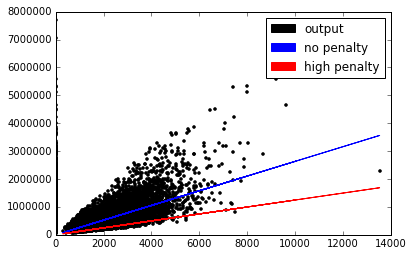

In [65]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


%matplotlib inline
line1 = plt.plot(simple_feature_matrix,output,'k.', label='output')
line2 = plt.plot(simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-', label='no penalty')
line3 = plt.plot(simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-', label='high penalty')

black_patch = mpatches.Patch(color='black', label='output')
blue_patch = mpatches.Patch(color='blue', label='no penalty')
red_patch = mpatches.Patch(color='red', label='high penalty')


plt.legend(handles=[black_patch, blue_patch, red_patch])

plt.show()
#plt.legend(handles=[line1, line2, line3])
#plt.legend([line1, line2, line3], ['output', 'no penalty', 'high penalty'])

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [66]:
def get_residual_sum_of_squares(feature_matrix, output,weights):
    pred = predict_outcome(feature_matrix, weights)
    RSS = np.sum(np.square(output - pred))
    return(RSS)

In [71]:
weights = np.array([0., 0.])
RSS_zero = get_residual_sum_of_squares(simple_test_feature_matrix, test_output, weights)
print RSS_zero

[ 0.  0.  0. ...,  0.  0.  0.]
1.78427328252e+15


In [72]:
weights = simple_weights_0_penalty
RSS_no_reg = get_residual_sum_of_squares(simple_test_feature_matrix, test_output, weights)
print RSS_no_reg

[ 376124.78641338  775921.67840077  449771.58230579 ...,  662821.24185171
  607586.1449324   268284.8352852 ]
2.75723643935e+14


In [73]:
weights = simple_weights_high_penalty
RSS_high_penalty = get_residual_sum_of_squares(simple_test_feature_matrix, test_output, weights)
print RSS_high_penalty

[ 178141.59604451  367493.84003556  213022.27256917 ...,  313927.08680125
  287766.57940775  127066.31970481]
6.94653089852e+14


***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?
2. Comparing the lines you fit with the with no regularization versus high regularization, which one is steeper?
3. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 


# Running a multiple regression with L2 penalty

Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, create Numpy versions of your training and test data with these two features. 

In [74]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [81]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_0_penalty`

In [82]:
l2_penalty = 0.0
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100)
print multiple_weights_0_penalty

[ 0.  0.  0. ...,  0.  0.  0.]
[ 112656.49646491  193285.58531031  151749.9225216  ...,  137277.19058288
  135503.53117881   91518.13330615]
[ 188360.71258178  323403.53741402  253376.5465893  ...,  229565.4283716
  226637.50522634  153043.6292995 ]
[ 239216.2999888   411042.92649451  321299.72816357 ...,  291600.53059296
  287934.63462679  194400.36682473]
[ 273362.48217303  470116.33608508  366561.15394223 ...,  333291.74859481
  329167.5922025   222194.51391338]
[ 296272.56204508  509979.4313693   396585.90533555 ...,  361302.65973819
  356908.11302164  240868.45578642]
[ 311627.11674653  536923.53077081  416367.04032432 ...,  380114.25445077
  375575.42855191  253409.5196065 ]
[ 321901.18650166  555179.30110888  429262.17774395 ...,  392739.8200774
  388141.29701766  261826.56374532]
[ 328759.13581522  567591.70275513  437529.16859947 ...,  401205.67189654
  396604.10833313  267470.46515055]
[ 333320.18195625  576073.86346366  442686.31376409 ...,  406874.42564908
  402307.70085333

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_high_penalty`

In [83]:
l2_penalty = 1e11
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100)
print multiple_weights_high_penalty

[ 0.  0.  0. ...,  0.  0.  0.]
[ 112656.49646491  193285.58531031  151749.9225216  ...,  137277.19058288
  135503.53117881   91518.13330615]
[ 165829.41703934  284746.4241025   223026.56583552 ...,  202109.99400556
  199536.80274111  134740.00638881]
[ 190909.58267208  328070.06010014  256369.09925128 ...,  232720.89340449
  229800.48845154  155147.27578909]
[ 202725.67134934  348627.70988443  271857.81608938 ...,  247167.42577992
  244107.22174334  164778.30003475]
[ 208281.86681486  358411.01702481  278965.74258421 ...,  253980.2114633
  250873.21058309  169320.15959604]
[ 210885.95593453  363089.32945244  282157.29899384 ...,  257188.95558695
  254075.13300244  171459.32467889]
[ 212099.61549765  365344.18445861  283532.84622127 ...,  258696.99833738
  255592.09244967  172464.68879657]
[ 212659.78546634  366444.880521    284077.65382462 ...,  259403.16712987
  256312.11377033  172935.47025222]
[ 212913.93372807  366992.99950283  284251.61039399 ...,  259731.78453515
  256654.9305658

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [84]:
weights = initial_weights
RSS_zeros_3 = get_residual_sum_of_squares(test_feature_matrix, test_output, weights)
print RSS_zeros_3

[ 0.  0.  0. ...,  0.  0.  0.]
1.78427328252e+15


In [85]:
weights = multiple_weights_0_penalty
RSS_0_penalty_3 = get_residual_sum_of_squares(test_feature_matrix, test_output, weights)
print RSS_0_penalty_3

[ 415246.88456424  730381.90785317  406029.82958631 ...,  680937.91408552
  584638.84044597  275617.72820303]
2.7600229659e+14


In [86]:
weights = multiple_weights_high_penalty
RSS_high_penalty_3 = get_residual_sum_of_squares(test_feature_matrix, test_output, weights)
print RSS_high_penalty_3

[ 270450.0878956   437752.47591692  237239.25824448 ...,  428217.95430592
  354883.2292128   173326.72841465]
5.00408150015e+14


Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.) How far is the prediction from the actual price?  Which weights perform best for the 1st house?

In [87]:
predictions_noPenalty = predict_outcome(test_feature_matrix, multiple_weights_0_penalty)
predictions_highPenalty = predict_outcome(test_feature_matrix, multiple_weights_high_penalty)



[ 415246.88456424  730381.90785317  406029.82958631 ...,  680937.91408552
  584638.84044597  275617.72820303]
[ 270450.0878956   437752.47591692  237239.25824448 ...,  428217.95430592
  354883.2292128   173326.72841465]


In [90]:
predictions_noPenalty

array([ 415246.88456424,  730381.90785317,  406029.82958631, ...,
        680937.91408552,  584638.84044597,  275617.72820303])

In [91]:
predictions_highPenalty

array([ 270450.0878956 ,  437752.47591692,  237239.25824448, ...,
        428217.95430592,  354883.2292128 ,  173326.72841465])

In [92]:
sales.head

<bound method SFrame.head of Columns:
	id	str
	date	datetime
	price	float
	bedrooms	float
	bathrooms	float
	sqft_living	float
	sqft_lot	int
	floors	str
	waterfront	int
	view	int
	condition	int
	grade	int
	sqft_above	int
	sqft_basement	int
	yr_built	int
	yr_renovated	int
	zipcode	str
	lat	float
	long	float
	sqft_living15	float
	sqft_lot15	float
	constant	int

Rows: 21613

Data:
+------------+---------------------------+-----------+----------+-----------+
|     id     |            date           |   price   | bedrooms | bathrooms |
+------------+---------------------------+-----------+----------+-----------+
| 7129300520 | 2014-10-13 00:00:00+00:00 |  221900.0 |   3.0    |    1.0    |
| 6414100192 | 2014-12-09 00:00:00+00:00 |  538000.0 |   3.0    |    2.25   |
| 5631500400 | 2015-02-25 00:00:00+00:00 |  180000.0 |   2.0    |    1.0    |
| 2487200875 | 2014-12-09 00:00:00+00:00 |  604000.0 |   4.0    |    3.0    |
| 1954400510 | 2015-02-18 00:00:00+00:00 |  510000.0 |   3.0    |    2.0  

***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?
2. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 
3. We make prediction for the first house in the test set using two sets of weights (no regularization vs high regularization). Which weights make better prediction <u>for that particular house</u>?